# Smooth and flux-calibrate the input spectra to match the ETC.

The goal of this notebook is to see if we can reproduce the NIRSpec/prism spectra produced by the JWST/ETC (which are in e-/s) by smoothing and "unfluxing" (i.e., applying the throughput curves) the input spectra, which are in mJy.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.table import Table

from prospect.utils.smoothing import smoothspec

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [3]:
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters', 'etc' )
pandeia_dir = os.path.join( os.getenv('IM_DATA_DIR'), 'pandeia_data-1.0' )

### Read the instrumental resolution. 

In [4]:
dispfile = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'dispersion', 'jwst_nirspec_prism_disp.fits')
print('Reading {}'.format(dispfile))
disp = Table(fitsio.read(dispfile, ext=1, upper=True))
outwave = disp['WAVELENGTH']

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/dispersion/jwst_nirspec_prism_disp.fits


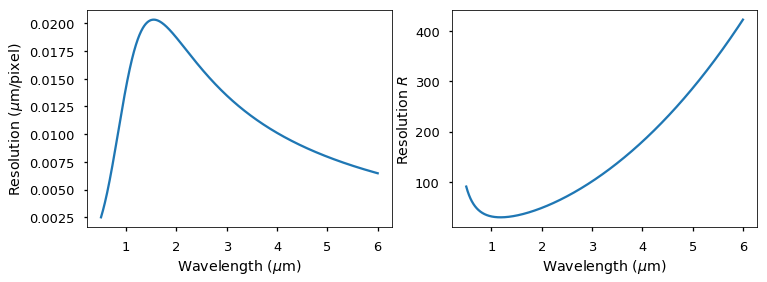

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(disp['WAVELENGTH'], disp['DLDS'])
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Resolution ($\mu$m/pixel)')

ax[1].plot(disp['WAVELENGTH'], disp['R'])
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Resolution $R$')

### Get the total throughput.

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/blaze/jwst_nirspec_prism_speceff.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/filters/jwst_nirspec_clear_trans.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/optical/jwst_nirspec_mos_internaloptics_throughput.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/telescope/jwst_telescope_ote_thruput.fits


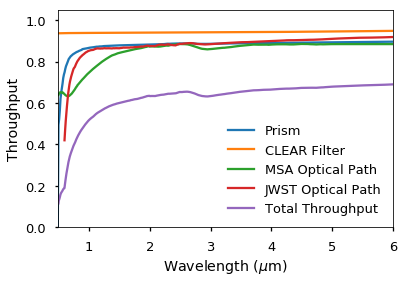

In [6]:
thru_prism = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'blaze', 
                          'jwst_nirspec_prism_speceff.fits') # prism throughput
thru_clear = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'filters', 
                          'jwst_nirspec_clear_trans.fits') # CLEAR filter throughput 
thru_optics = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'optical', 
                           'jwst_nirspec_mos_internaloptics_throughput.fits') # NIRSpec MSA optical path
thru_telescope = os.path.join(pandeia_dir, 'jwst', 'telescope', 
                              'jwst_telescope_ote_thruput.fits') # JWST optical path
labels = ['Prism', 'CLEAR Filter', 'MSA Optical Path', 'JWST Optical Path']

thru = []

for lab, thrufile in zip( labels, (thru_prism, thru_clear, thru_optics, thru_telescope) ):
    print('Reading {}'.format(thrufile))
    tt = Table(fitsio.read(thrufile, ext=1, upper=True))
    thru.append(tt)
    plt.plot(tt['WAVELENGTH'], tt['THROUGHPUT'], label=lab)
    
throughput = np.ones_like(outwave)
for tt in thru:
    throughput *= np.interp(outwave, tt['WAVELENGTH'], tt['THROUGHPUT'])
plt.plot(outwave, throughput, label='Total Throughput')

plt.xlim(outwave.min(), outwave.max())
plt.ylim(0, 1.05)
plt.ylabel('Throughput')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend(loc='lower right', frameon=False)   

### Read the input model spectra, smooth them, multiply by the throughput, and compare to the ETC output spectra.

Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_00.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_01.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_02.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_03.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_04.txt
Reading /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_05.txt


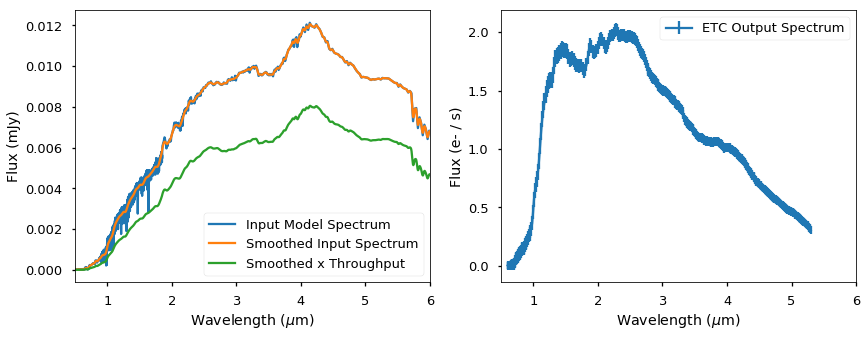

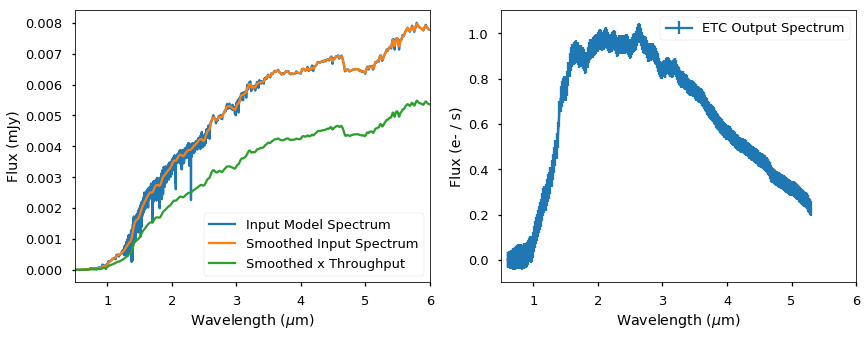

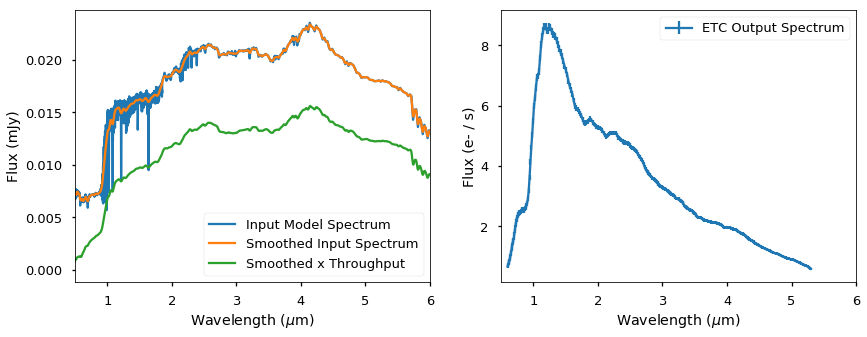

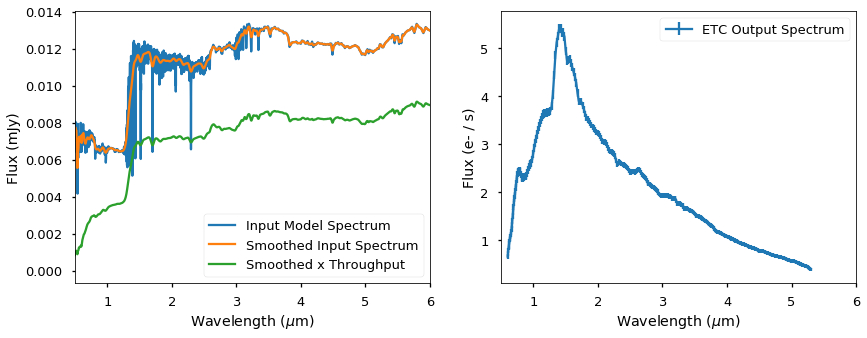

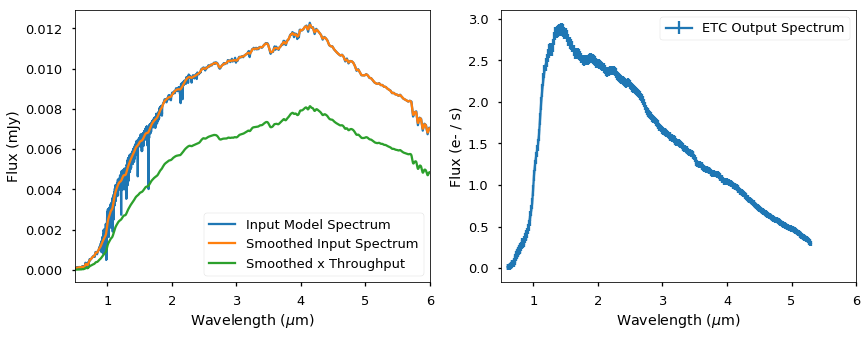

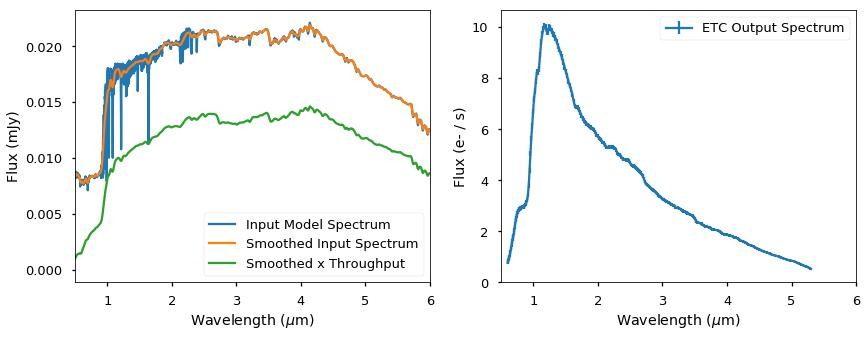

In [7]:
for suffix in ('00', '01', '02', '03', '04', '05'):
    infile = os.path.join(jwstdir, 'input', 'modelspec_{}.txt'.format(suffix))
    print('Reading {}'.format(infile))
    inwave, influx = np.loadtxt(infile, unpack=True)
    
    outfile = os.path.join(jwstdir, 'output', suffix, 'lineplot', 'lineplot_extracted_flux.fits')
    snrfile = os.path.join(jwstdir, 'output', suffix, 'lineplot', 'lineplot_sn.fits')
    simspec = Table(fitsio.read(outfile, ext=1, upper=True))
    snrspec = Table(fitsio.read(snrfile, ext=1, upper=True))

    resolution = np.interp(inwave, disp['WAVELENGTH'], disp['DLDS'])    
    smoothflux = smoothspec(inwave, influx, resolution=resolution, smoothtype='lsf', 
                            outwave=outwave, fftsmooth=True)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    ax[0].plot(inwave, influx, label='Input Model Spectrum')
    ax[0].plot(outwave, smoothflux, label='Smoothed Input Spectrum')
    ax[0].plot(outwave, smoothflux * throughput, label='Smoothed x Throughput')
    ax[0].set_ylabel('Flux (mJy)')
    ax[0].set_xlabel('Wavelength ($\mu$m)')
    ax[0].legend(loc='lower right')

    ax[1].errorbar(simspec['WAVELENGTH'], simspec['EXTRACTED_FLUX'], 
                   simspec['EXTRACTED_FLUX'] / snrspec['SN'], label='ETC Output Spectrum')
    ax[1].set_ylabel('Flux (e- / s)')
    ax[1].set_xlabel('Wavelength ($\mu$m)')
    ax[1].legend(loc='upper right')
        
    [xx.set_xlim(outwave.min(), outwave.max()) for xx in ax]